In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [2]:
np.random.seed(123)

boston = datasets.load_boston()
cancer =  datasets.load_breast_cancer()

In [3]:
X_boston = boston['data']
y_boston = boston['target']

X_cancer = cancer['data']
y_cancer = cancer['target']

# X_boston = normalize(X_boston)
# X_cancer = normalize(X_cancer)
X_boston = (X_boston-X_boston.mean(axis=0))/X_boston.std(axis=0)
X_cancer = (X_cancer-X_cancer.mean(axis=0))/X_cancer.std(axis=0)

In [4]:
X_boston_train, X_boston_test, y_boston_train, y_boston_test = train_test_split(X_boston, y_boston, test_size=0.25, random_state=0)
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer, test_size=0.25, random_state=0)

In [5]:
## activation functions

def ReLU(h):
    return np.maximum(h, 0)

def sigmoid(h):
    return 1/(1+np.exp(-h))

def linear(h):
    return h

activation_function_dict = {
    'ReLU': ReLU,
    'sigmoid': sigmoid,
    'linear': linear
}

In [7]:
class FeedForwardNeuralNetwork:
    
    
    def fit(self, X, Y, n_hidden, f1 = 'ReLU', f2 = 'linear', loss = 'RSS', lr = 1e-5, n_iter = 5e3, seed = None):
        
        ## Store Information
        self.X = X
        self.Y = Y.reshape(len(Y), -1)
        self.N = len(X)
        self.D_X = self.X.shape[1]
        self.D_Y = self.Y.shape[1]
        self.Xt = self.X.T
        self.Yt = self.Y.T
        self.D_h = n_hidden
        self.f1, self.f2 = f1, f2
        self.loss = loss
        self.lr = lr
        self.n_iter = int(n_iter)
        self.seed = seed
        
        ## Instantiate Weights
        np.random.seed(self.seed)
        self.W1 = np.random.randn(self.D_h, self.D_X)/5
        self.c1 = np.random.randn(self.D_h, 1)/5
        self.W2 = np.random.randn(self.D_Y, self.D_h)/5
        self.c2 = np.random.randn(self.D_Y, 1)/5
        
        ## Instantiate Outputs
        self.H1 = (self.W1 @ self.Xt) + self.c1
        self.Z1 = activation_function_dict[self.f1](self.H1)
        self.H2 = (self.W2 @ self.Z1) + self.c2
        self.Yhatt = activation_function_dict[self.f2](self.H2)
        
        ## Fit Weights
        for iteration in range(self.n_iter):
            
            # Yhat #
            if self.loss == 'RSS':
                self.dL_dYhatt = -(self.Yt - self.Yhatt) # (D_Y x N)
            elif self.loss == 'log':
                self.dL_dYhatt = (-(self.Yt/self.Yhatt) + (1-self.Yt)/(1-self.Yhatt)) # (D_y x N)
            
            # H2 #
            if self.f2 == 'linear':
                self.dYhatt_dH2 = np.ones((self.D_Y, self.N))
            elif self.f2 == 'sigmoid':
                self.dYhatt_dH2 = sigmoid(self.H2) * (1- sigmoid(self.H2))
            self.dL_dH2 = self.dL_dYhatt * self.dYhatt_dH2 # (D_Y x N)

            # c2 # 
            self.dL_dc2 = np.sum(self.dL_dH2, 1) # (D_y)
            
            # W2 # 
            self.dL_dW2 = np.tensordot(self.dL_dH2, self.Z1, (1,1)) # (D_Y x D_h)
            
            # Z1 #
            self.dL_dZ1 = np.tensordot(self.W2, self.dL_dH2, (0, 0)) # (D_h x N)
            
            # H1 #
            if self.f1 == 'ReLU':
                self.dL_dH1 = self.dL_dZ1 * np.maximum(self.H1, 0) # (D_h x N)
            elif self.f1 == 'linear':
                self.dL_dH1 = self.dL_dZ1 # (D_h x N)
            
            # c1 #
            self.dL_dc1 = np.sum(self.dL_dH1, 1) # (D_h)
            
            # W1 # 
            self.dL_dW1 = np.tensordot(self.dL_dH1, self.Xt, (1,1)) # (D_h, D_X)
            
            ## Update Weights
            self.W1 -= self.lr * self.dL_dW1
            self.c1 -= self.lr * self.dL_dc1.reshape(-1, 1)           
            self.W2 -= self.lr * self.dL_dW2            
            self.c2 -= self.lr * self.dL_dc2.reshape(-1, 1)                    
            
            ## Update Outputs
            self.H1 = (self.W1 @ self.Xt) + self.c1
            self.Z1 = activation_function_dict[self.f1](self.H1)
            self.H2 = (self.W2 @ self.Z1) + self.c2
            self.Yhatt = activation_function_dict[self.f2](self.H2)  
            
    def predict(self, X_test):
        X_testt = X_test.T
        self.h1 = (self.W1 @ X_testt) + self.c1
        self.z1 = activation_function_dict[self.f1](self.h1)
        self.h2 = (self.W2 @ self.z1) + self.c2
        self.Yhatt = activation_function_dict[self.f2](self.h2)        
        return self.Yhatt

In [8]:
ffnn = FeedForwardNeuralNetwork()
ffnn.fit(X_boston_train, y_boston_train, n_hidden=8)
y_boston_test_hat = ffnn.predict(X_boston_test)


C:\Users\wilso\Anaconda3\envs\ia-tools\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


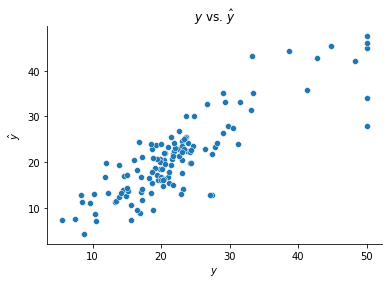

In [9]:
fig, ax = plt.subplots()
sns.scatterplot(y_boston_test, y_boston_test_hat[0])
ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = r'$y$ vs. $\hat{y}$')
sns.despine()

In [16]:
ffnn = FeedForwardNeuralNetwork()
ffnn.fit(X_cancer_train, y_cancer_train, n_hidden = 3,
         loss = 'log', f2 = 'sigmoid', seed = 123, lr = 1e-4)
y_cancer_test_hat = ffnn.predict(X_cancer_test)
np.mean(y_cancer_test_hat.round() == y_cancer_test)

0.9440559440559441